In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from sklearn import metrics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [4]:
def load_data():
    train_data, validation_data, test_data = tfds.load(
        name="imdb_reviews",
        split=('train[:60%]', 'train[60%:]', 'test'),
        as_supervised=True)

    return train_data, validation_data, test_data

def build_model():
    embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
    hub_layer = hub.KerasLayer(embedding, input_shape=[],
                               dtype=tf.string, trainable=True)

    model = tf.keras.Sequential([
        hub_layer,
        tf.keras.layers.Dense(32, activation='relu', name='hidden-layer-2'),
        tf.keras.layers.Dense(16, activation='relu', name='hidden-layer-3'),
        tf.keras.layers.Dense(1, name='output-layer')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

def train_model(model, train_data, validation_data, epochs=5):
    history = model.fit(train_data.shuffle(10000).batch(512),
                        epochs=epochs,
                        validation_data=validation_data.batch(512),
                        verbose=1)
    return history

def evaluate_model(model, test_data):
    results = model.evaluate(test_data.batch(512), verbose=2)

    for name, value in zip(model.metrics_names, results):
        print("%s: %.3f" % (name, value))

def plot_metrics(history):
    pd.DataFrame(history.history).plot(figsize=(10,7))
    plt.title("Metrics Graph")
    plt.show()

def prepare_test_data(test_data):
    texts = []
    true_labels = []
    for text, label in test_data:
        texts.append(text.numpy())
        true_labels.append(label.numpy())
    texts = np.array(texts)
    true_labels = np.array(true_labels)
    return texts, true_labels

def predict_and_evaluate(model, texts, true_labels):
    predicted_probs = model.predict(texts)
    predicted_labels = (predicted_probs > 0.5).astype(int)

    report = metrics.classification_report(true_labels, predicted_labels, target_names=['Negative', 'Positive'])
    print(report)

    cm = metrics.confusion_matrix(true_labels, predicted_labels)
    plot_confusion_matrix(cm, class_names=['Negative', 'Positive'])
    plt.title("Confusion Matrix")
    plt.show()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKOE2DI/imdb_reviews-train.tfrecord…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKOE2DI/imdb_reviews-test.tfrecord*…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incompleteKOE2DI/imdb_reviews-unsupervised.t…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 128)               124642688 
                                                                 
 hidden-layer-2 (Dense)      (None, 32)                4128      
                                                                 
 hidden-layer-3 (Dense)      (None, 16)                528       
                                                                 
 output-layer (Dense)        (None, 1)                 17        
                                                                 
Total params: 124647361 (475.49 MB)
Trainable params: 124647361 (475.49 MB)
Non-trainable params: 0 (0.00 Byte)
________________________________________________________________

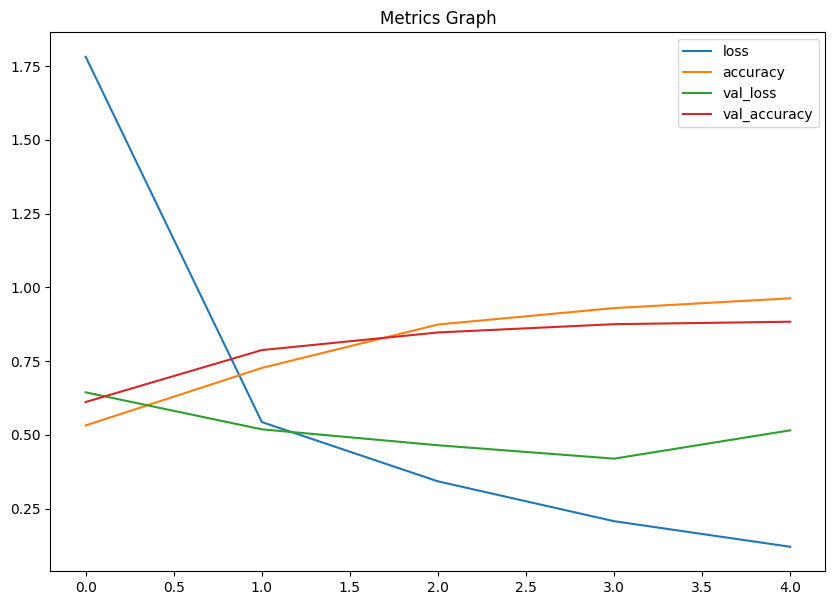

782/782 [==============================] - 390s 498ms/step
              precision    recall  f1-score   support

    Negative       0.84      0.90      0.87     12500
    Positive       0.89      0.82      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



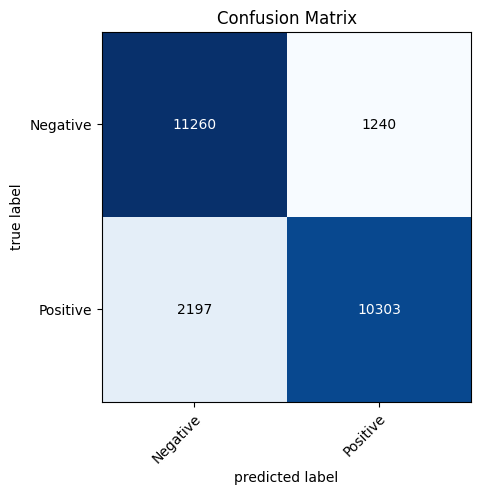

In [5]:
train_data, validation_data, test_data = load_data()
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))

model = build_model()
tf.keras.utils.plot_model(model, show_shapes=True)
model.summary()

history = train_model(model, train_data, validation_data, epochs=5)
evaluate_model(model, test_data)
plot_metrics(history)

texts, true_labels = prepare_test_data(test_data)
predict_and_evaluate(model, texts, true_labels)